In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm
from scipy.sparse import csr_matrix

from sim_modules.testfuncs import gen_in_out_one_in_subs

import time

plt.ion()

In [221]:
N = 500
sigm_w = 1.
sigm_w_in = 1.

cf = 0.1
cf_in = 1.

dim_in = 1
dim_out = 1

n_it = 1
n_it_a = 15000

tau_task = 10

T_batch_BPTT = tau_task
T_batch_w_out = N*5
T_prerun = 20
reg_fact = 0.01

eps_a = 0.00001

In [222]:
## init
W = np.random.normal(0.,sigm_w/(N*cf)**.5,(N,N))*(np.random.rand(N,N) <= cf)
W[range(N),range(N)] = 0.

W_sp = csr_matrix(W)

W_t = np.array(W)

w_in = np.random.normal(0.,sigm_w_in,(N,dim_in))
w_out = (np.random.rand(dim_out,N+1)-.5)*0.1

a = .5 * np.ones((N))

dLdy = np.ndarray((T_batch_BPTT,N))
dyda = np.ndarray((T_batch_BPTT,N))

delta_a = np.zeros((N))

## recording
a_rec = np.ndarray((n_it*n_it_a,N))
w_out_rec = np.ndarray((n_it,dim_out,N+1))

In [223]:
def run_network(u_in,u_out,W,a,w_in,w_out):
    
    T_sim = u_in.shape[1]
    
    y = np.ndarray((T_sim,W.shape[0]+1))
    X = np.ndarray((T_sim,W.shape[0]))
    
    y[0,1:] = 0.
    y[:,0] = 1.
    
    X[0,:] = 0.
    
    for t in range(1,T_sim):
        X[t,:] = W.dot(y[t-1,1:]) + w_in @ u_in[:,t]
        y[t,1:] = np.tanh(a*X[t,:])
    
    return y,X    

In [224]:
def calc_w_out(y,u_out,reg_fact):
    
    N = y.shape[1]
    
    return (np.linalg.inv(y.T @ y + reg_fact*np.eye(N)) @ y.T @ u_out).T

In [233]:
def backprop_dLdy(y,W,a,w_out,err):
    
    Wt = W.T
    
    T = y.shape[0]
    N = W.shape[0]
    
    dLdy = np.zeros((T,N))
    
    
    dLdy[-1,:] = w_out[:,1:].T @ err[-1,:]
    
    for t in range(0,T-1):
        dLdy[-2-t,:] += w_out[:,1:].T @ err[-2-t,:]
        dLdy[-2-t,:] += Wt @ ((1.-y[-1-t,:]**2.)*a*dLdy[-1-t,:])
    
    return dLdy
    

In [234]:
for n in tqdm(range(n_it)):
    
    ### w_out
    u_in,u_out = gen_in_out_one_in_subs(T_batch_w_out+T_prerun,tau_task)
    u_in = np.array([u_in])
    u_out = np.array([u_out]).T
    
    y,X = run_network(u_in,u_out,W,a,w_in,w_out)
    
    y = y[T_prerun:,:]
    X = X[T_prerun:,:]
    
    w_out = calc_w_out(y,u_out[T_prerun:,:],reg_fact)
    
    ### gains
    for n_a in tqdm(range(n_it_a)):
        u_in,u_out = gen_in_out_one_in_subs(T_batch_BPTT+T_prerun,tau_task)
        u_in = np.array([u_in])
        u_out = np.array([u_out]).T

        y,X = run_network(u_in,u_out,W,a,w_in,w_out)

        y = y[T_prerun:,:]
        X = X[T_prerun:,:]

        O = (y @ w_out.T)

        err = O - u_out[T_prerun:,:]
        
        dLdy = backprop_dLdy(y[:,1:],W,a,w_out,err)

        dyda = (1.-y[:,1:]**2.)*X

        dLda = (dyda*dLdy).sum(axis=0)

        a -= eps_a * dLda
        
        a_rec[n*n_it_a + n_a,:] = a
        
    
    w_out_rec[n,:,:] = w_out
    

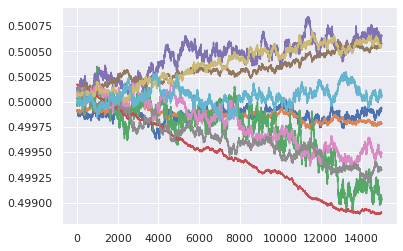

In [235]:
plt.plot(a_rec[:,:10])

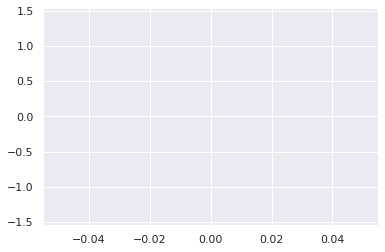

In [182]:
plt.plot(w_out_rec[:,0,:10])

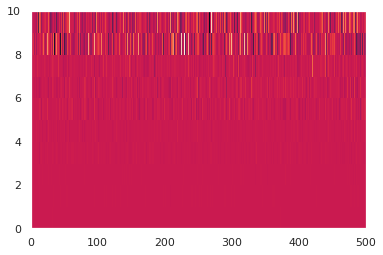

In [192]:
plt.pcolormesh(dLdy*dyda)